# Abstract

The final IBM Capstone Project required that we work on a real dataset with the aim of providing students with a practical experience of what data scientists go through in the real world using Foursquare location data. The final assignment required that students define a business problem and target audience, describe the data and how it would be used to solve the problem, define a methodology and describe any exploratory data analysis and inferential statistical testing, present results and discuss observations, and finally provide a conclusion to the report to assist the target audience with decision making. The project will explore potential neighborhoods in Toronto to open an Italian Restaurant.


# 1. Introduction

## Background and Business Problem
Toronto is the provincial capital of Ontario and also the most populous city in Canada, with a population of 2,731,571 as per 2016 census. Toronto is a city that is rich in history, full of interesting events and cultural ethnicities that have made the city great. The diverse population of Toronto reflects its role as an important destination for immigrants to Canada. More than 50 percent of residents belong to a visible minority population group and over 200 distinct ethnic origins are represented among its inhabitants. Toronto is also popularly known as one of the biggest entertainment hubs of the country with a variety of bars, theatres, and restaurants representing a plethora of ethnic cultures. Among these bustling ethinic cultures, are the Italian Canadians, which Canada's Official Statistical office revealed that the Italians were the 6th largest ethnic group in Canada constituting  1,587,970 Canadians with full or partial Italian descent or 4.6% of the country's total population.

A significant part of the Italian heritage enjoyed world over is their Italian cuisine. Italian cuisine is known for its regional diversity, especially between the north and the south of the Italian peninsula. It offers an abundance of taste, and is one of the most popular and copied in the world. It influenced several cuisines around the world, chiefly that of North America. Italian cuisine is generally characterized by its simplicity, with many dishes having only two to four main ingredients. Italian cooks rely chiefly on the quality of the ingredients rather than on elaborate preparation. Given the significant presence of the Italian community and Toronto being the entertainment hub of Canada, Toronto presents a great setting to open an Italian Restaurants. This project will go through step by step process to make a decision whether it is a good idea to open an Italian restaurant. The neighborhoods in Toronto will be analyzed to identify the most profitable areas since the success of the restaurant depends on factors such as the presence of a vibrant Italian community and the presence similar establishments in the area. 

## Target Audience
Audiences that would be interested in this project and the types of clients or groups who stand to benefit from this detailed analysis may include:

1. Existing restaurant owners or restaurant chain owners looking to expand into the Canadaian market can benefit from gaining insights through targeted placement of new branches that target the Italian community.  
2. Prospective business owners looking to break into the hospitality industry and start their own business can benefit from insights derived from assessing the risks and benefits of certain locations.  
3. Italian restaurant enthusiastss who wish to find neighborhoods with options for Italian cuisine.

## Data Description  

To carry out the analysis, secondary data was collected from different sources. The datasets used are are as follows:  

* For data on the neighborhoods of Toronto, I used “List of Postal code of Canada: M” which was webscraped using wikipedia link https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M. The page contains the name of each neighpborhood including the postal code and borough which I then wrangle, clean and read into a *pandas* dataframe so that it is structured. This dataframe provides the basis of the analysis and give an understanding of the Toronto landscape.  


* For the dataset above to be complete, it required geographical coordinates to the mapped to each postal code. The geographical coodinates are pertinent to establishing clusters and the venue available in each cluster. For information on the geographical coordinates of the Toronto neighborhoods I used the csv file - https://cocl.us/Geospatial_data.  


* Given that the project requires that we identify the most suitable areas to for an Italian restaurant, the dataset required information on the ethnic distribution of the Toronto population to identify areas that are more densely populated by Italian communities. To obtain this information I downloaded Toronto's neighborhood profile from the city of Toronto's Open Data portal - https://open.toronto.ca/dataset/neighbourhood-profiles/. The CSV file I downloaded has information on a wide range of topics including household income, age demographics,marital status etc.   


* To obtain information on venues present in the different loactions of Toronto, I used the Foursquare API which provides general information on the various venues such as their name, geographical location and category.

# 2. Methodology

## Data Collection and Preparation

### Scraping Neighborhood Data from Wikipedia
The initial step of this process involves scraping the Wikipedia page 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:M' in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe.

#### Assumptions

1) The dataframe consists of only three columns: PostalCode, Borough, and Neighborhood.

2) The only cells that have been processed are cells that have an assigned borough. Cells with a borough that is Not assigned have been ignored.

3) More than one neighborhood can exist in one postal code area.

4) If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.

In [1]:
!pip install folium

     |████████████████████████████████| 92kB 15.7MB/s eta 0:00:01


In [2]:
#Libraries imported for this exercise

import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json

from geopy.geocoders import Nominatim

import requests

import io

from pandas.io.json import json_normalize 

import matplotlib.cm as cm

import matplotlib.colors as colors

from sklearn.cluster import KMeans

import folium

print('Libraries imported.')

Libraries imported.


In [3]:
url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

In [4]:
toronto_data = pd.read_html(url, header = 0)[0]
toronto_data.head()

Postcode           Borough     Neighbourhood
0      M1A      Not assigned      Not assigned
1      M2A      Not assigned      Not assigned
2      M3A        North York         Parkwoods
3      M4A        North York  Victoria Village
4      M5A  Downtown Toronto      Harbourfront

In [5]:
#As stated in the assuptions the only cells that will be processed are cells that have an assigned borough. Cells with a borough that is Not assigned will be ignored.
toronto_data = toronto_data[toronto_data.Borough != 'Not assigned'] 

#To allow us to merge the location and demographics data to the dataframe, the reference column will need to have a shared name 'PostalCode'
toronto_data = toronto_data.rename(columns={'Postcode': 'PostalCode'})
toronto_data = toronto_data.rename(columns={'Neighbourhood': 'Neighborhood'})

#A cell that has a borough but is Not assigned to a neighborhood, then the neighborhood will be given the same name as the borough
for index, row in toronto_data.iterrows():
    if row['Neighborhood'] == 'Not assigned':
        row['Neighborhood'] = row['Borough']

toronto_data.head()

PostalCode           Borough      Neighborhood
2        M3A        North York         Parkwoods
3        M4A        North York  Victoria Village
4        M5A  Downtown Toronto      Harbourfront
5        M6A        North York  Lawrence Heights
6        M6A        North York    Lawrence Manor

In [6]:
#To understand our data, it is important to know the number of rows and columns in the dataframe
print('The dataframe has the following rows and columns: ', toronto_data.shape)

The dataframe has the following rows and columns:  (210, 3)


## Mapping Coordinated to Neighborhoods
After creating the dataframe of the neighbourhoods, the next logical step is to merge the longitudinal and latitudinal coordinates of the neighborhoods to the dataframe. The location data has been provided in the csv file (http://cocl.us/Geospatial_data).

In [7]:
coordinates = "https://cocl.us/Geospatial_data"

neighborhood_latlon = requests.get(coordinates).text
neighborhood_latlon_data = pd.read_csv(io.StringIO(neighborhood_latlon))

neighborhood_latlon_data.head()

Postal Code   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476

In [8]:
#The reference column 'Postal Code' should be renamed to match the same format as column 'PostalCode' in the first dataframe to allow for merging of the two dataframes
neighborhood_latlon_data = neighborhood_latlon_data.rename(columns={'Postal Code': 'PostalCode'})

#Merge the two dataframes
toronto_dataframe = pd.merge(toronto_data, neighborhood_latlon_data, on='PostalCode')
toronto_dataframe.head()

PostalCode           Borough      Neighborhood   Latitude  Longitude
0        M3A        North York         Parkwoods  43.753259 -79.329656
1        M4A        North York  Victoria Village  43.725882 -79.315572
2        M5A  Downtown Toronto      Harbourfront  43.654260 -79.360636
3        M6A        North York  Lawrence Heights  43.718518 -79.464763
4        M6A        North York    Lawrence Manor  43.718518 -79.464763

In [9]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(len(toronto_dataframe['Borough'].unique()),toronto_dataframe.shape[0]))

The dataframe has 11 boroughs and 210 neighborhoods.


## Demographic Data
I downloaded Toronto's neighborhood profile from the link https://open.toronto.ca/dataset/neighbourhood-profiles/ as a csv file, which I cleaned up by removing all irrelevant data that didn't pertain to ethnicity or income before I read the cvs and created a dataframe.

In [37]:
# Uploading a csv file from your machine onto Watson Studio
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_7e596acc239d4a88b10a6c5c2bf90130 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='UKkYkgitNFMBowdyIBErbhWCQsStKZSt1v3kMKofBPwO',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_7e596acc239d4a88b10a6c5c2bf90130.get_object(Bucket='courseracapstoneproject-donotdelete-pr-ifdy1bnlikaeku',Key='toronto_neighborhood_profiles_data.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# Reading the CSV file 
neighborhood_profile = pd.read_csv(body)
neighborhood_profile.head()

Neighborhood    Under $5000    $5000 to $9999    $10000 to $14999  \
0  Agincourt North            150               105                 165   
1        Agincourt            320               130                 205   
2        Alderwood             70                35                  80   
3        The Annex            905               485                 660   
4  Don Mills North            300               150                 245   

     $15000 to $19999    $20000 to $24999    $25000 to $29999  \
0                 450                 340                 565   
1                 275                 350                 415   
2                  85                 160                 175   
3                 785                 680                 625   
4                 435                 430                 495   

     $30000 to $34999    $35000 to $39999    $40000 to $44999  \
0                 450                 510                 455   
1                 395                 450                 470   
2                 170                 210                 185   
3                 630                 675                 645   
4                 500                 575                 555   

     $45000 to $49999    $50000 to $59999    $60000 to $69999  \
0                 475                 930                 755   
1                 445                 860                 755   
2                 225                 390                 355   
3                 665                1160                1060   
4                 575                1180                1000   

     $70000 to $79999    $80000 to $89999    $90000 to $99999  \
0                 695                 640                 500   
1                 630                 500                 405   
2                 365                 310                 265   
3                 820                 750                 620   
4                 790                 690                 595   

       $100000 to $124999      $125000 to $149999      $150000 to $199999  \
0                     935                     465                     510   
1                     700                     370                     425   
2                     605                     445                     470   
3                    1205                     780                    2765   
4                    1030                     660                    1915   

   Population Ethnic Group #1  Group 1 Count Ethnic Group #2  Group 2 Count  \
0       32350         Chinese          16950      Sri Lankan           2230   
1       27185         Chinese          11455     East Indian           2180   
2       18985         English           2320        Canadian           2245   
3       50305         English           6745           Irish           5235   
4       38050         Chinese           4850         English           3615   

  Ethnic Group #3  Group 3 Count Ethnic Group #4  Group 4 Count  \
0     East Indian           2090        Filipino           1465   
1        Filipino           1405      Sri Lankan           1145   
2           Irish           1900         Italian           1275   
3        Canadian           4655          German           3030   
4           Irish           3075        Canadian           3035   

  Ethnic Group #5  Group 5 Count Ethnic Group #6  Group 6 Count  \
0        Canadian           1295         English            870   
1        Canadian           1125         English            985   
2          Polish           1225          German            940   
3          French           2665          Polish           2445   
4     East Indian           2365          German           1295   

  Ethnic Group #7  Group 7 Count Ethnic Group #8  Group 8 Count  \
0           Tamil            855        Jamaican            780   
1        Jamaican            645         Italian            630   
2          French            850       Ukraini

In [38]:
# Remove all incomes
neighborhood_profile.drop(neighborhood_profile.iloc[:, 1:19], inplace = True, axis = 1)
neighborhood_profile.head()

Neighborhood  Population Ethnic Group #1  Group 1 Count Ethnic Group #2  \
0  Agincourt North       32350         Chinese          16950      Sri Lankan   
1        Agincourt       27185         Chinese          11455     East Indian   
2        Alderwood       18985         English           2320        Canadian   
3        The Annex       50305         English           6745           Irish   
4  Don Mills North       38050         Chinese           4850         English   

   Group 2 Count Ethnic Group #3  Group 3 Count Ethnic Group #4  \
0           2230     East Indian           2090        Filipino   
1           2180        Filipino           1405      Sri Lankan   
2           2245           Irish           1900         Italian   
3           5235        Canadian           4655          German   
4           3615           Irish           3075        Canadian   

   Group 4 Count Ethnic Group #5  Group 5 Count Ethnic Group #6  \
0           1465        Canadian           1295         English   
1           1145        Canadian           1125         English   
2           1275          Polish           1225          German   
3           3030          French           2665          Polish   
4           3035     East Indian           2365          German   

   Group 6 Count Ethnic Group #7  Group 7 Count Ethnic Group #8  \
0            870           Tamil            855        Jamaican   
1            985        Jamaican            645         Italian   
2            940          French            850       Ukrainian   
3           2445         Chinese           2400         Italian   
4           1295        Filipino           1280          Polish   

   Group 8 Count Ethnic Group #9  Group 9 Count Ethnic Group #10  \
0            780           Irish            425          Italian   
1            630           Irish            620            Tamil   
2            810      Portuguese            740         Filipino   
3           2170         Russian           1790           Jewish   
4           1225          French           1100          Italian   

   Group 10 Count Ethnic Group #11  Group 11 Count Ethnic Group #12  \
0             335          Spanish             335       Vietnamese   
1             425        Pakistani             410            Greek   
2             660      East Indian             495          Chinese   
3            1235        Ukrainian            1110      East Indian   
4            1040          Iranian             875            Greek   

   Group 12 Count         Ethnic Group #13  Group 13 Count Ethnic Group #14  \
0             320               Portuguese             275           French   
1             395   Trinidadian/Tobagonian             305           German   
2             420                Slovenian             390         Croatian   
3             965                    Dutch             940         American   
4             830                  Russian             825         Romanian   

   Group 14 Count Ethnic Group #15  Group 15 Count  \
0             265         Guyanese             245   
1             280          Spanish             270   
2             300          Russian             225   
3             705            Welsh             690   
4             670           Korean             575   

                         Ethnic Group #16  Group 16 Count Ethnic Group #17  \
0                     West Indian; n.o.s.             235        Pakistani   
1                                  French             255           Afghan   
2   First Nations (North American Indian)             200            Greek   
3                               Hungarian             685          Spanish   
4                               Ukrainian             460        Hungarian   

   Group 17 Count Ethnic Group #18  Group 18 Count      Ethnic Group #19  \
0             230           German             225                 Greek   
1             255         Guyanese             240   

In [39]:
neighborhood_profile.shape

(140, 472)

In [40]:
# Only the first 10 ethinic groups are required per neighborhood, remove all others
neighborhood_profile.drop(neighborhood_profile.iloc[:, 22:], inplace = True, axis = 1)
neighborhood_profile.head()

Neighborhood  Population Ethnic Group #1  Group 1 Count Ethnic Group #2  \
0  Agincourt North       32350         Chinese          16950      Sri Lankan   
1        Agincourt       27185         Chinese          11455     East Indian   
2        Alderwood       18985         English           2320        Canadian   
3        The Annex       50305         English           6745           Irish   
4  Don Mills North       38050         Chinese           4850         English   

   Group 2 Count Ethnic Group #3  Group 3 Count Ethnic Group #4  \
0           2230     East Indian           2090        Filipino   
1           2180        Filipino           1405      Sri Lankan   
2           2245           Irish           1900         Italian   
3           5235        Canadian           4655          German   
4           3615           Irish           3075        Canadian   

   Group 4 Count Ethnic Group #5  Group 5 Count Ethnic Group #6  \
0           1465        Canadian           1295         English   
1           1145        Canadian           1125         English   
2           1275          Polish           1225          German   
3           3030          French           2665          Polish   
4           3035     East Indian           2365          German   

   Group 6 Count Ethnic Group #7  Group 7 Count Ethnic Group #8  \
0            870           Tamil            855        Jamaican   
1            985        Jamaican            645         Italian   
2            940          French            850       Ukrainian   
3           2445         Chinese           2400         Italian   
4           1295        Filipino           1280          Polish   

   Group 8 Count Ethnic Group #9  Group 9 Count Ethnic Group #10  \
0            780           Irish            425          Italian   
1            630           Irish            620            Tamil   
2            810      Portuguese            740         Filipino   
3           2170         Russian           1790           Jewish   
4           1225          French           1100          Italian   

   Group 10 Count  
0             335  
1             425  
2             660  
3            1235  
4            1040

In [41]:
neighborhood_profile.columns

Index(['Neighborhood', 'Population', 'Ethnic Group #1', 'Group 1 Count',
       'Ethnic Group #2', 'Group 2 Count', 'Ethnic Group #3', 'Group 3 Count',
       'Ethnic Group #4', 'Group 4 Count', 'Ethnic Group #5', 'Group 5 Count',
       'Ethnic Group #6', 'Group 6 Count', 'Ethnic Group #7', 'Group 7 Count',
       'Ethnic Group #8', 'Group 8 Count', 'Ethnic Group #9', 'Group 9 Count',
       'Ethnic Group #10', 'Group 10 Count'],
      dtype='object')

In [42]:
neighborhood_profile.shape

(140, 22)

## Leveraging Foursquare Location Data API
Foursquare API is very usefule online application used my many developers & other application like Uber etc. In this project I have used it to retrieve informtion about the places present in the neighborhoods of Toronto. The API returns a JSON file and we need to turn that into a data-frame. Here I’ve chosen 100 popular spots for each neighborhood within a radius of 1km.

In [15]:
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

In [16]:
address = 'Toronto'

geolocator = Nominatim(user_agent="to_explorer")

location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto are 43.653963, -79.387207.


The map below shows a bird's eye view of Toronto and its various neighborhoods that will be used to analyse the data.

In [69]:
# Creating a map of Toronto
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# Adding markers to the map
for lat, lng, borough, neighborhood in zip(toronto_dataframe['Latitude'], 
                                           toronto_dataframe['Longitude'], 
                                           toronto_dataframe['Borough'], 
                                           toronto_dataframe['Neighborhood']):
    label = '{}, {}'.format(toronto_dataframe, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [19]:
LIMIT = 100
radius = 500

toronto_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)

In [20]:
#Creating a function to get the category

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [21]:
results = requests.get(toronto_url).json()
results

{'meta': {'code': 200, 'requestId': '5e1f5cdf0be7b4001bfd5786'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Bay Street Corridor',
  'headerFullLocation': 'Bay Street Corridor, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 79,
  'suggestedBounds': {'ne': {'lat': 43.6584630045, 'lng': -79.38099903084075},
   'sw': {'lat': 43.649462995499995, 'lng': -79.39341496915925}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5227bb01498e17bf485e6202',
       'name': 'Downtown Toronto',
       'location': {'lat': 43.65323167517444,
        'lng': -79.38529600606677,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65323167517444,
          

In [22]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

name        categories        lat        lng
0    Downtown Toronto      Neighborhood  43.653232 -79.385296
1             Japango  Sushi Restaurant  43.655268 -79.385165
2         Cafe Plenty              Café  43.654571 -79.389450
3           Poke Guys        Poke Place  43.654895 -79.385052
4  Sansotei Ramen 三草亭  Ramen Restaurant  43.655157 -79.386501

In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            

        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            

        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [24]:
LIMIT = 100
toronto_venues = getNearbyVenues(names=toronto_dataframe['Neighborhood'],
                    latitudes=toronto_dataframe['Latitude'],
                    longitudes=toronto_dataframe['Longitude'])

Parkwoods
Victoria Village
Harbourfront
Lawrence Heights
Lawrence Manor
Queen's Park
Queen's Park
Rouge
Malvern
Don Mills North
Woodbine Gardens
Parkview Hill
Ryerson
Garden District
Glencairn
Cloverdale
Islington
Martin Grove
Princess Gardens
West Deane Park
Highland Creek
Rouge Hill
Port Union
Flemingdon Park
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Bloordale Gardens
Eringate
Markland Wood
Old Burnhamthorpe
Guildwood
Morningside
West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor
Downsview North
Wilson Heights
Thorncliffe Park
Adelaide
King
Richmond
Dovercourt Village
Dufferin
Scarborough Village
Fairview
Henry Farm
Oriole
Northwood Park
York University
East Toronto
Harbourfront East
Toronto Islands
Union Station
Little Portugal
Trinity
East Birchmount Park
Ionview
Kennedy Park
Bayview Village
CFB Toronto
Downsview East
The Danforth West
Riverdale
Design Exchange
Toronto 

In [25]:
toronto_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0         Parkwoods              43.753259              -79.329656   
1         Parkwoods              43.753259              -79.329656   
2         Parkwoods              43.753259              -79.329656   
3  Victoria Village              43.725882              -79.315572   
4  Victoria Village              43.725882              -79.315572   

                    Venue  Venue Latitude  Venue Longitude     Venue Category  
0         Brookbanks Park       43.751976       -79.332140               Park  
1         GTA Restoration       43.753396       -79.333477    Fireworks Store  
2           Variety Store       43.751974       -79.333114  Food & Drink Shop  
3  Victoria Village Arena       43.723481       -79.315635       Hockey Arena  
4             Tim Hortons       43.725517       -79.313103        Coffee Shop

In [26]:
toronto_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                               
Adelaide                                                             100   
Agincourt                                                              4   
Agincourt North                                                        2   
Albion Gardens                                                        10   
Alderwood                                                             10   
Bathurst Manor                                                        19   
Bathurst Quay                                                         17   
Bayview Village                                                        4   
Beaumond Heights                                                      10   
Bedford Park                                                          26   
Berczy Park                                                           56   
Birch Cliff                                                            4   
Bloordale Gardens                                                      8   
Brockton                                                              22   
Business Reply Mail Processing Centre 969 Eastern                     16   
CFB Toronto                                                            4   
CN Tower                                                              17   
Cabbagetown                                                           42   
Caledonia-Fairbanks                                                    4   
Canada Post Gateway Processing Centre                                 11   
Cedarbrae                                                              8   
Central Bay Street                                                    87   
Chinatown                                                             90   
Christie                                                              17   
Church and Wellesley                                                  82   
Clairlea                                                              10   
Clarks Corners                                                        12   
Cliffcrest                                                             2   
Cliffside                                                              2   
Cliffside West                                                         4   
Cloverdale                                                             1   
Commerce Court                                                       100   
Davisville                                                            33   
Davisville North                                                       8   
Deer Park                                                             15   
Del Ray                                                                4   
Design Exchange                                                      100   
Don Mills North                                                        5   
Don Mills South                                                       22   
Dorset Park                                                            6   
Dovercourt Village                                                    15   
Downsview                                                              4   
Downsview Central                                                      4   
Downsview East                                                         4   
Downsview North                                                       19   
Downsview Northwest                                                    4   
Downsview West                                                         5   
Dufferin                                                              15   
East Birchmount Park                                                   6   
East Toronto                                                           2   
Emery                                                                  2   
Eringate               

In [27]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 273 uniques categories.


To get dummies of venue categories, one hot encoding is used which will allow us to calculate the mean of all venues grouped by their neighborhoods.

In [28]:
#one hot encoding
trn_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# adding neighborhood column back to dataframe
trn_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# moving neighborhood column to the first column
fixed_columns = [trn_onehot.columns[-1]] + list(trn_onehot.columns[:-1])
trn_onehot = trn_onehot[fixed_columns]
trn_grouped = trn_onehot.groupby('Neighborhood').mean().reset_index()

trn_grouped.head()

Neighborhood  Yoga Studio  Accessories Store  Afghan Restaurant  \
0         Adelaide          0.0                0.0                0.0   
1        Agincourt          0.0                0.0                0.0   
2  Agincourt North          0.0                0.0                0.0   
3   Albion Gardens          0.0                0.0                0.0   
4        Alderwood          0.0                0.0                0.0   

   Airport  Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0      0.0                 0.0           0.0             0.0              0.0   
1      0.0                 0.0           0.0             0.0              0.0   
2      0.0                 0.0           0.0             0.0              0.0   
3      0.0                 0.0           0.0             0.0              0.0   
4      0.0                 0.0           0.0             0.0              0.0   

   Airport Terminal  American Restaurant  Antique Shop  Aquarium  Art Gallery  \
0               0.0                 0.02           0.0       0.0         0.01   
1               0.0                 0.00           0.0       0.0         0.00   
2               0.0                 0.00           0.0       0.0         0.00   
3               0.0                 0.00           0.0       0.0         0.00   
4               0.0                 0.00           0.0       0.0         0.00   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auto Garage  \
0                  0.0              0.03                 0.0          0.0   
1                  0.0              0.00                 0.0          0.0   
2                  0.0              0.00                 0.0          0.0   
3                  0.0              0.00                 0.0          0.0   
4                  0.0              0.00                 0.0          0.0   

   Auto Workshop  BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank   Bar  \
0            0.0        0.0         0.0         0.0    0.02   0.0  0.04   
1            0.0        0.0         0.0         0.0    0.00   0.0  0.00   
2            0.0        0.0         0.0         0.0    0.00   0.0  0.00   
3            0.0        0.0         0.0         0.0    0.00   0.0  0.00   
4            0.0        0.0         0.0         0.0    0.00   0.0  0.00   

   Baseball Field  Baseball Stadium  Basketball Court  Basketball Stadium  \
0             0.0               0.0               0.0                 0.0   
1             0.0               0.0               0.0                 0.0   
2             0.0               0.0               0.0                 0.0   
3             0.0               0.0               0.0                 0.0   
4             0.0               0.0               0.0                 0.0   

   Beach  Bed & Breakfast  Beer Bar  Beer Store  Belgian Restaurant  \
0    0.0              0.0       0.0         0.0                 0.0   
1    0.0              0.0       0.0         0.0                 0.0   
2    0.0              0.0       0.0         0.0                 0.0   
3    0.0              0.0       0.0         0.1                 0.0   
4    0.0              0.0       0.0         0.0                 0.0   

   Bike Shop  Bistro  Boat or Ferry  Bookstore  Boutique  \
0        0.0     0.0            0.0       0.01       0.0   
1        0.0     0.0            0.0       0.00       0.0   
2        0.0     0.0            0.0       0.00       0.0   
3        0.0     0.0            0.0       0.00       0.0   
4        0.0     0.0            0.0       0.00       0.0   

   Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
0                  0.01            0.02      0.0          0.0   
1                  0.00            0.25      0.0          0.0   
2                  0.00            0.00      0.0          0.0   
3                  0.00            0.00      0.0          0.0   
4                  0.00            0.00      0.0          0.0   

   Bubble Tea Shop  Building  Burger 

In [29]:
print (toronto_venues['Venue Category'].value_counts())

Coffee Shop                        346
Café                               189
Pizza Place                        115
Restaurant                         105
Bakery                              98
Bar                                 97
Sandwich Place                      84
Italian Restaurant                  79
Park                                79
Hotel                               75
Japanese Restaurant                 73
Fast Food Restaurant                71
Gym                                 61
Burger Joint                        57
Clothing Store                      54
Grocery Store                       53
Sushi Restaurant                    53
Pharmacy                            51
American Restaurant                 47
Pub                                 45
Steakhouse                          45
Vegetarian / Vegan Restaurant       44
Breakfast Spot                      43
Gastropub                           42
Fried Chicken Joint                 41
Asian Restaurant         

The table shows that there are 273 unique categories. There are 84 Italian Restaurants currently listed among the venues available in Toronto. Italian restaurants also occupy the highest number of themed restaurant, showing that this is a very popular choice of restaurant amoung customers in Toronto. This can be advantageous to the potential business owner as there is a large market for Italian cuisine and great opportunity to differentiate.

# 3. Exploratory Data Analysis

## Exploring the relationship between Neighborhood and Italian Restaurants

In [30]:
#Extracting Italian Restaurant by Neighborhood
restaurant_by_neighborhood = trn_grouped[['Neighborhood', 'Italian Restaurant']]
restaurant_by_neighborhood

Neighborhood  Italian Restaurant
0                                             Adelaide            0.000000
1                                            Agincourt            0.000000
2                                      Agincourt North            0.000000
3                                       Albion Gardens            0.000000
4                                            Alderwood            0.000000
5                                       Bathurst Manor            0.000000
6                                        Bathurst Quay            0.000000
7                                      Bayview Village            0.000000
8                                     Beaumond Heights            0.000000
9                                         Bedford Park            0.076923
10                                         Berczy Park            0.017857
11                                         Birch Cliff            0.000000
12                                   Bloordale Gardens            0.000000
13                                            Brockton            0.045455
14   Business Reply Mail Processing Centre 969 Eastern            0.000000
15                                         CFB Toronto            0.000000
16                                            CN Tower            0.000000
17                                         Cabbagetown            0.047619
18                                 Caledonia-Fairbanks            0.000000
19               Canada Post Gateway Processing Centre            0.000000
20                                           Cedarbrae            0.000000
21                                  Central Bay Street            0.045977
22                                           Chinatown            0.000000
23                                            Christie            0.058824
24                                Church and Wellesley            0.012195
25                                            Clairlea            0.000000
26                                      Clarks Corners            0.083333
27                                          Cliffcrest            0.000000
28                                           Cliffside            0.000000
29                                      Cliffside West            0.000000
30                                          Cloverdale            0.000000
31                                      Commerce Court            0.030000
32                                          Davisville            0.060606
33                                    Davisville North            0.000000
34                                           Deer Park            0.000000
35                                             Del Ray            0.000000
36                                     Design Exchange            0.030000
37                                     Don Mills North            0.000000
38                                     Don Mills South            0.045455
39                                         Dorset Park            0.000000
40                                  Dovercourt Village            0.000000
41                                           Downsview            0.000000
42                                   Downsview Central            0.000000
43                                      Downsview East            0.000000
44                                     Downsview North            0.000000
45                                 Downsview Northwest            0.000000
46                                      Downsview West            0.000000
47                                            Dufferin            0.000000
48                                East Birchmount Park            0.000000
49                                        East Toronto            0.000000
50                                               Emery            0.000000
51                                            Eringate            0.000000
52                                    Exhibition Place            0

In [31]:
#Merging italian restaurants to original dataframe
toronto_merged = pd.merge(toronto_dataframe, restaurant_by_neighborhood, on='Neighborhood')
toronto_merged

PostalCode           Borough  \
0          M3A        North York   
1          M4A        North York   
2          M5A  Downtown Toronto   
3          M6A        North York   
4          M6A        North York   
5          M7A  Downtown Toronto   
6          M9A      Queen's Park   
7          M1B       Scarborough   
8          M1B       Scarborough   
9          M3B        North York   
10         M4B         East York   
11         M4B         East York   
12         M5B  Downtown Toronto   
13         M5B  Downtown Toronto   
14         M6B        North York   
15         M9B         Etobicoke   
16         M9B         Etobicoke   
17         M9B         Etobicoke   
18         M9B         Etobicoke   
19         M9B         Etobicoke   
20         M1C       Scarborough   
21         M1C       Scarborough   
22         M1C       Scarborough   
23         M3C        North York   
24         M3C        North York   
25         M4C         East York   
26         M5C  Downtown Toronto   
27         M4X  Downtown Toronto   
28         M6C              York   
29         M9C         Etobicoke   
30         M9C         Etobicoke   
31         M9C         Etobicoke   
32         M9C         Etobicoke   
33         M1E       Scarborough   
34         M1E       Scarborough   
35         M1E       Scarborough   
36         M4E      East Toronto   
37         M5E  Downtown Toronto   
38         M6E              York   
39         M1G       Scarborough   
40         M4G         East York   
41         M5G  Downtown Toronto   
42         M6G  Downtown Toronto   
43         M1H       Scarborough   
44         M2H        North York   
45         M3H        North York   
46         M3H        North York   
47         M3H        North York   
48         M4H         East York   
49         M5H  Downtown Toronto   
50         M5H  Downtown Toronto   
51         M5H  Downtown Toronto   
52         M6H      West Toronto   
53         M6H      West Toronto   
54         M1J       Scarborough   
55         M2J        North York   
56         M2J        North York   
57         M2J        North York   
58         M3J        North York   
59         M3J        North York   
60         M4J         East York   
61         M5J  Downtown Toronto   
62         M5J  Downtown Toronto   
63         M5J  Downtown Toronto   
64         M6J      West Toronto   
65         M6J      West Toronto   
66         M1K       Scarborough   
67         M1K       Scarborough   
68         M1K       Scarborough   
69         M2K        North York   
70         M3K        North York   
71         M3K        North York   
72         M4K      East Toronto   
73         M4K      East Toronto   
74         M5K  Downtown Toronto   
75         M5K  Downtown Toronto   
76         M6K      West Toronto   
77         M6K      West Toronto   
78         M6K      West Toronto   
79         M1L       Scarborough   
80         M1L       Scarborough   
81         M1L       Scarborough   
82         M2L        North York   
83         M2L        North York   
84         M3L        North York   
85         M4L      East Toronto   
86         M4L      East Toronto   
87         M5L  Downtown Toronto   
88         M5L  Downtown Toronto   
89         M6L        North York   
90         M6L        North York   
91         M6L        North York   
92         M9L        North York   
93         M1M       Scarborough   
94         M1M       Scarborough   
95         M1M       Scarborough   
96         M3M        North York   
97         M4M      East Toronto   
98         M5M        North York   
99         M5M        North York   
100        M6M              York   
101        M6M              York   
102        M6M              York   
103        M6M              York   
104        M9M        North York   
105        M9M        North York   
106        M1N       Scarborough   
107        M1N       Scarborough   
108        M2N        North York   
109        M3N        North York   
110     

Visualization tools allow for a better understanding of the data. A categorical plot will help in identifying the boroughs with densely populated Italian restaurants while a bar graph can show the spread of the restaurants across Toronto. a Violin plot will help visualize the concentration of Italian restaurants in each borough.

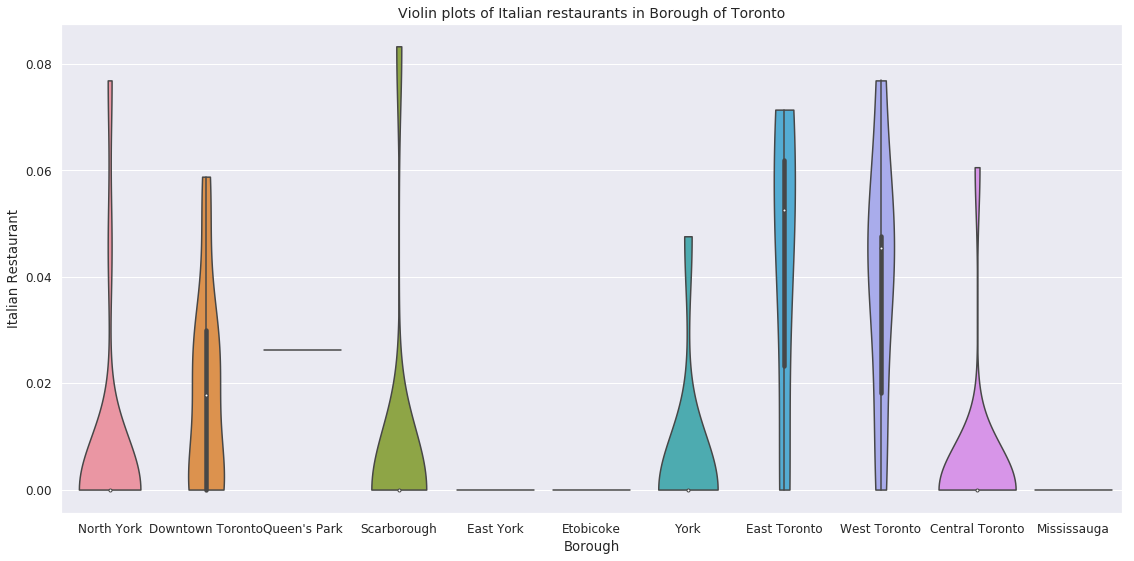

In [32]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


fig = plt.figure(figsize=(19,9))

sns.set(font_scale=1.1)
sns.violinplot(y="Italian Restaurant", x="Borough", data=toronto_merged, cut=0);

plt.title('Violin plots of Italian restaurants in Borough of Toronto', fontsize=14)
plt.show()

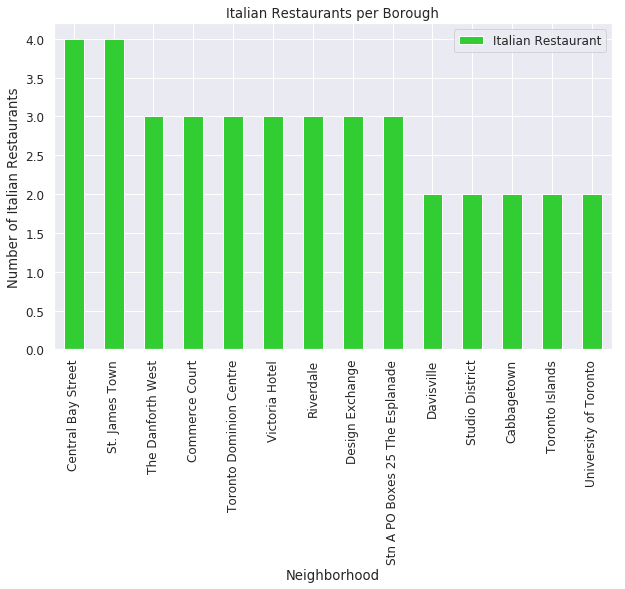

In [33]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

graph = pd.DataFrame(trn_onehot.groupby('Neighborhood')['Italian Restaurant'].sum())
graph = graph.sort_values(by ='Italian Restaurant', ascending=False)
graph.iloc[:14].plot(kind='bar', figsize=(10,6), color='limegreen')
plt.xlabel("Neighborhood")
plt.ylabel("Number of Italian Restaurants")
plt.title("Italian Restaurants per Borough")
plt.show()

A pie chart can be used to represent the overall distribution of Italian restaurants per borough

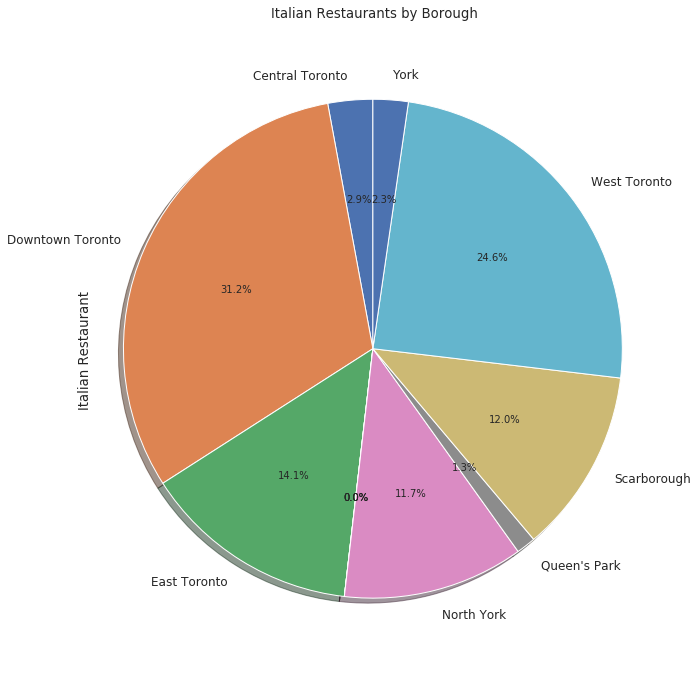

In [34]:
restaurant_by_borough = toronto_merged.set_index('Borough')
restaurant_by_borough = restaurant_by_borough.groupby(['Borough']).sum()

restaurant_by_borough['Italian Restaurant'].plot(kind='pie',
                            figsize=(10, 12),
                            autopct='%1.1f%%', # add in percentages
                            startangle=90,     # start angle 90° 
                            shadow=True,       # add shadow      
                           )

plt.title('Italian Restaurants by Borough')
plt.axis('equal') # Sets the pie chart to look like a circle.

plt.show()

The next step is to merge the tables we have populated and filter them to show the neighborhoods that are represented by the Italian demographic.

In [44]:
neighborhood_profile.columns

Index(['Neighborhood', 'Population', 'Ethnic Group #1', 'Group 1 Count',
       'Ethnic Group #2', 'Group 2 Count', 'Ethnic Group #3', 'Group 3 Count',
       'Ethnic Group #4', 'Group 4 Count', 'Ethnic Group #5', 'Group 5 Count',
       'Ethnic Group #6', 'Group 6 Count', 'Ethnic Group #7', 'Group 7 Count',
       'Ethnic Group #8', 'Group 8 Count', 'Ethnic Group #9', 'Group 9 Count',
       'Ethnic Group #10', 'Group 10 Count'],
      dtype='object')

In [45]:
ethnic_df = neighborhood_profile[['Neighborhood', 'Population',
       'Ethnic Group #1', 'Group 1 Count', 'Ethnic Group #2', 'Group 2 Count',
       'Ethnic Group #3', 'Group 3 Count', 'Ethnic Group #4', 'Group 4 Count',
       'Ethnic Group #5', 'Group 5 Count', 'Ethnic Group #6', 'Group 6 Count',
       'Ethnic Group #7', 'Group 7 Count', 'Ethnic Group #8', 'Group 8 Count',
       'Ethnic Group #9', 'Group 9 Count', 'Ethnic Group #10',
       'Group 10 Count']]

ethnic_df

Neighborhood  Population Ethnic Group #1  \
0                     Agincourt North       32350         Chinese   
1                           Agincourt       27185         Chinese   
2                           Alderwood       18985         English   
3                           The Annex       50305         English   
4                     Don Mills North       38050         Chinese   
5                      Bathurst Manor       22180        Filipino   
6                  Central Bay Street       35235         Chinese   
7                     Bayview Village       27380         Chinese   
8                        Steeles East       16355         Chinese   
9                        Bedford Park       37335        Canadian   
10            Beechborough-Greenbrook        7490      Portuguese   
11                            Bendale       36415         Chinese   
12                          Cliffside       35675         English   
13                        Black Creek       25375      Vietnamese   
14                        Blake-Jones       13000         English   
15               Briar Hill-Belgravia       19005        Filipino   
16                         York Mills       14515         English   
17                    Broadview North       17285         English   
18                Brookhaven-Amesbury       21885         Italian   
19                        Cabbagetown       18665         English   
20                Caledonia-Fairbanks       12565      Portuguese   
21                          Casa Loma       19575         English   
22             Centennial Scarborough       20080         English   
23               Church and Wellesley       47675         English   
24                           Clairlea       34660        Canadian   
25                       Clanton Park       24160        Filipino   
26                         Cliffcrest       24135         English   
27             Corso Italia-Davenport       21380      Portuguese   
28                  The Danforth West       16575         English   
29                  The Danforth West       28155         English   
30                 Don Valley Village       33210         Chinese   
31                        Dorset Park       30230        Filipino   
32                 Dovercourt Village       56075      Portuguese   
33                          Downsview       43355         Italian   
34                           Dufferin       18965      Portuguese   
35                  The Danforth West       36575         English   
36           Edenbridge-Humber Valley       22605         Italian   
37                      Eglinton East       27720        Filipino   
38                   Elms-Old Rexdale       12185        Canadian   
39                      Lawrence Park       33005        Filipino   
40                           Eringate       27480        Canadian   
41                Etobicoke West Mall       15620         English   
42                    Flemingdon Park       25980     East Indian   
43                  Forest Hill North       20955          Polish   
44                     Forest Hill SE       18370          Polish   
45             Glenfield-Jane Heights       35845         Italian   
46                  Greenwood-Coxwell       24730         English   
47                          Guildwood       15295         English   
48                         Henry Farm       19100         Chinese   
49                          High Park       36325         English   
50                            Swansea       41425         English   
51                     Highland Creek       16265     East Indian   
52                  Hillcrest Village       20140         Chinese   
53                          Westmount       13785         Italian   
54                      Humber Summit       14460         Italian   
55                         Humber Bay       18720     East Indian   
56                 Humewood-Cedarvale       24385        Canadian   
57                     

In [46]:
print (ethnic_df.loc[15,'Ethnic Group #2'])

 Italian


In [47]:
italian = ethnic_df.loc[15,'Ethnic Group #2']

In [48]:
#Filtering the Neighborhoods with Italian ethnic crowd
temp = ethnic_df[(ethnic_df['Ethnic Group #1'] == italian)| 
                                      (ethnic_df['Ethnic Group #2'] == italian)|
                                      (ethnic_df['Ethnic Group #3'] == italian)|
                                      (ethnic_df['Ethnic Group #4'] == italian)|
                                      (ethnic_df['Ethnic Group #5'] == italian)|
                                      (ethnic_df['Ethnic Group #6'] == italian)|
                                      (ethnic_df['Ethnic Group #7'] == italian)|
                                      (ethnic_df['Ethnic Group #8'] == italian)|
                                      (ethnic_df['Ethnic Group #9'] == italian)|
                                      (ethnic_df['Ethnic Group #10'] == italian)]
italian_df = pd.DataFrame(temp).reset_index()
italian_df.drop('index',axis=1,inplace=True)

italian_df

Neighborhood  Population Ethnic Group #1  \
0                     Agincourt North       32350         Chinese   
1                           Agincourt       27185         Chinese   
2                           Alderwood       18985         English   
3                           The Annex       50305         English   
4                     Don Mills North       38050         Chinese   
5                      Bathurst Manor       22180        Filipino   
6                  Central Bay Street       35235         Chinese   
7                        Steeles East       16355         Chinese   
8                        Bedford Park       37335        Canadian   
9             Beechborough-Greenbrook        7490      Portuguese   
10                            Bendale       36415         Chinese   
11                          Cliffside       35675         English   
12                        Black Creek       25375      Vietnamese   
13               Briar Hill-Belgravia       19005        Filipino   
14                         York Mills       14515         English   
15                    Broadview North       17285         English   
16                Brookhaven-Amesbury       21885         Italian   
17                        Cabbagetown       18665         English   
18                Caledonia-Fairbanks       12565      Portuguese   
19                          Casa Loma       19575         English   
20             Centennial Scarborough       20080         English   
21               Church and Wellesley       47675         English   
22                           Clairlea       34660        Canadian   
23                       Clanton Park       24160        Filipino   
24                         Cliffcrest       24135         English   
25             Corso Italia-Davenport       21380      Portuguese   
26                  The Danforth West       16575         English   
27                  The Danforth West       28155         English   
28                 Dovercourt Village       56075      Portuguese   
29                          Downsview       43355         Italian   
30                           Dufferin       18965      Portuguese   
31                  The Danforth West       36575         English   
32           Edenbridge-Humber Valley       22605         Italian   
33                   Elms-Old Rexdale       12185        Canadian   
34                      Lawrence Park       33005        Filipino   
35                           Eringate       27480        Canadian   
36                Etobicoke West Mall       15620         English   
37                     Forest Hill SE       18370          Polish   
38             Glenfield-Jane Heights       35845         Italian   
39                  Greenwood-Coxwell       24730         English   
40                          Guildwood       15295         English   
41                          High Park       36325         English   
42                            Swansea       41425         English   
43                     Highland Creek       16265     East Indian   
44                          Westmount       13785         Italian   
45                      Humber Summit       14460         Italian   
46                         Humber Bay       18720     East Indian   
47                 Humewood-Cedarvale       24385        Canadian   
48                          Islington       61135         English   
49                 The Junction North       24605         English   
50                         Keelesdale       13495      Portuguese   
51                  Kensington Market       24530         Chinese   
52                  Kingsview Village       27100          Somali   
53           Kingsway Park South East       15810         English   
54                 Lambton Baby Point       13685         English   
55                    L'Amoreaux East       51600         Chinese   
56                      Lawrence Park       26475         English   
57                     

In [49]:
#retaining only Italian ethnic count & the neighborhood name 
columns_list = italian_df.columns.to_list()
italian_df_count = pd.DataFrame()

#removing Neighborhood & Population from the column names list
del columns_list[0]
del columns_list[0]


for i in range(0,italian_df.shape[0]):
    for j in columns_list:
        print(j)
        if italian_df.at[i, j] == italian:
            k = columns_list.index(j) + 1
            count_col = columns_list[k]
            italian_df_count = italian_df_count.append({'Neighborhood':italian_df.at[i, 'Neighborhood'], 'Population':italian_df.at[i, 'Population']
                                                                           , 'Ethnicity': italian_df.at[i, j], 'Count': italian_df.at[i, count_col]},ignore_index=True)

italian_df_count

Ethnic Group #1
Group 1 Count
Ethnic Group #2
Group 2 Count
Ethnic Group #3
Group 3 Count
Ethnic Group #4
Group 4 Count
Ethnic Group #5
Group 5 Count
Ethnic Group #6
Group 6 Count
Ethnic Group #7
Group 7 Count
Ethnic Group #8
Group 8 Count
Ethnic Group #9
Group 9 Count
Ethnic Group #10
Group 10 Count
Ethnic Group #1
Group 1 Count
Ethnic Group #2
Group 2 Count
Ethnic Group #3
Group 3 Count
Ethnic Group #4
Group 4 Count
Ethnic Group #5
Group 5 Count
Ethnic Group #6
Group 6 Count
Ethnic Group #7
Group 7 Count
Ethnic Group #8
Group 8 Count
Ethnic Group #9
Group 9 Count
Ethnic Group #10
Group 10 Count
Ethnic Group #1
Group 1 Count
Ethnic Group #2
Group 2 Count
Ethnic Group #3
Group 3 Count
Ethnic Group #4
Group 4 Count
Ethnic Group #5
Group 5 Count
Ethnic Group #6
Group 6 Count
Ethnic Group #7
Group 7 Count
Ethnic Group #8
Group 8 Count
Ethnic Group #9
Group 9 Count
Ethnic Group #10
Group 10 Count
Ethnic Group #1
Group 1 Count
Ethnic Group #2
Group 2 Count
Ethnic Group #3
Group 3 Count
Ethn

Group 1 Count
Ethnic Group #2
Group 2 Count
Ethnic Group #3
Group 3 Count
Ethnic Group #4
Group 4 Count
Ethnic Group #5
Group 5 Count
Ethnic Group #6
Group 6 Count
Ethnic Group #7
Group 7 Count
Ethnic Group #8
Group 8 Count
Ethnic Group #9
Group 9 Count
Ethnic Group #10
Group 10 Count
Ethnic Group #1
Group 1 Count
Ethnic Group #2
Group 2 Count
Ethnic Group #3
Group 3 Count
Ethnic Group #4
Group 4 Count
Ethnic Group #5
Group 5 Count
Ethnic Group #6
Group 6 Count
Ethnic Group #7
Group 7 Count
Ethnic Group #8
Group 8 Count
Ethnic Group #9
Group 9 Count
Ethnic Group #10
Group 10 Count
Ethnic Group #1
Group 1 Count
Ethnic Group #2
Group 2 Count
Ethnic Group #3
Group 3 Count
Ethnic Group #4
Group 4 Count
Ethnic Group #5
Group 5 Count
Ethnic Group #6
Group 6 Count
Ethnic Group #7
Group 7 Count
Ethnic Group #8
Group 8 Count
Ethnic Group #9
Group 9 Count
Ethnic Group #10
Group 10 Count
Ethnic Group #1
Group 1 Count
Ethnic Group #2
Group 2 Count
Ethnic Group #3
Group 3 Count
Ethnic Group #4
Grou

Group 1 Count
Ethnic Group #2
Group 2 Count
Ethnic Group #3
Group 3 Count
Ethnic Group #4
Group 4 Count
Ethnic Group #5
Group 5 Count
Ethnic Group #6
Group 6 Count
Ethnic Group #7
Group 7 Count
Ethnic Group #8
Group 8 Count
Ethnic Group #9
Group 9 Count
Ethnic Group #10
Group 10 Count
Ethnic Group #1
Group 1 Count
Ethnic Group #2
Group 2 Count
Ethnic Group #3
Group 3 Count
Ethnic Group #4
Group 4 Count
Ethnic Group #5
Group 5 Count
Ethnic Group #6
Group 6 Count
Ethnic Group #7
Group 7 Count
Ethnic Group #8
Group 8 Count
Ethnic Group #9
Group 9 Count
Ethnic Group #10
Group 10 Count
Ethnic Group #1
Group 1 Count
Ethnic Group #2
Group 2 Count
Ethnic Group #3
Group 3 Count
Ethnic Group #4
Group 4 Count
Ethnic Group #5
Group 5 Count
Ethnic Group #6
Group 6 Count
Ethnic Group #7
Group 7 Count
Ethnic Group #8
Group 8 Count
Ethnic Group #9
Group 9 Count
Ethnic Group #10
Group 10 Count
Ethnic Group #1
Group 1 Count
Ethnic Group #2
Group 2 Count
Ethnic Group #3
Group 3 Count
Ethnic Group #4
Grou

Count Ethnicity                      Neighborhood  Population
0     335.0   Italian                   Agincourt North     32350.0
1     630.0   Italian                         Agincourt     27185.0
2    1275.0   Italian                         Alderwood     18985.0
3    2170.0   Italian                         The Annex     50305.0
4    1040.0   Italian                   Don Mills North     38050.0
5    1785.0   Italian                    Bathurst Manor     22180.0
6    1020.0   Italian                Central Bay Street     35235.0
7     360.0   Italian                      Steeles East     16355.0
8    1505.0   Italian                      Bedford Park     37335.0
9     610.0   Italian           Beechborough-Greenbrook      7490.0
10    780.0   Italian                           Bendale     36415.0
11   1205.0   Italian                         Cliffside     35675.0
12   1565.0   Italian                       Black Creek     25375.0
13   1655.0   Italian              Briar Hill-Belgravia     19005.0
14    740.0   Italian                        York Mills     14515.0
15    530.0   Italian                   Broadview North     17285.0
16   1985.0   Italian               Brookhaven-Amesbury     21885.0
17    605.0   Italian                       Cabbagetown     18665.0
18   1270.0   Italian               Caledonia-Fairbanks     12565.0
19    705.0   Italian                         Casa Loma     19575.0
20    900.0   Italian            Centennial Scarborough     20080.0
21   1665.0   Italian              Church and Wellesley     47675.0
22   1210.0   Italian                          Clairlea     34660.0
23   1705.0   Italian                      Clanton Park     24160.0
24    905.0   Italian                        Cliffcrest     24135.0
25   2920.0   Italian            Corso Italia-Davenport     21380.0
26   1160.0   Italian                 The Danforth West     16575.0
27   1415.0   Italian                 The Danforth West     28155.0
28   3155.0   Italian                Dovercourt Village     56075.0
29   8205.0   Italian                         Downsview     43355.0
30    740.0   Italian                          Dufferin     18965.0
31   1275.0   Italian                 The Danforth West     36575.0
32   2590.0   Italian          Edenbridge-Humber Valley     22605.0
33    880.0   Italian                  Elms-Old Rexdale     12185.0
34   1195.0   Italian                     Lawrence Park     33005.0
35   2135.0   Italian                          Eringate     27480.0
36    740.0   Italian               Etobicoke West Mall     15620.0
37    445.0   Italian                    Forest Hill SE     18370.0
38   4310.0   Italian            Glenfield-Jane Heights     35845.0
39    840.0   Italian                 Greenwood-Coxwell     24730.0
40    545.0   Italian                         Guildwood     15295.0
41   1320.0   Italian                         High Park     36325.0
42   1785.0   Italian                           Swansea     41425.0
43    665.0   Italian                    Highland Creek     16265.0
44   2295.0   Italian                         Westmount     13785.0
45   2970.0   Italian                     Humber Summit     14460.0
46   1620.0   Italian                        Humber Bay     18720.0
47   1110.0   Italian                Humewood-Cedarvale     24385.0
48   4195.0   Italian                         Islington     61135.0
49   1015.0   Italian                The Junction North     24605.0
50   1060.0   Italian                        Keelesdale     13495.0
51    585.0   Italian                 Kensington Market     24530.0
52   2730.0   Italian                 Kingsview Village     27100.0
53   1075.0   Italian          Kingsway Park South East     15810.0
54    615.0   Italian                Lambton Baby Point     13685.0
55   1270.0   Italian                   L'Amoreaux East     51600.0
56    975.0   Italian                     Lawrence Park     26475.0
57   1035.0   Italian                     Lawrence Park     27

In [50]:
italian_population = italian_df_count[['Neighborhood','Count']]
italian_population = pd.merge(italian_population,toronto_merged,on='Neighborhood')
italian_population = italian_population[['Borough','Neighborhood','Count']]
italian_population = italian_population.sort_values(by='Count', ascending=False)
italian_population.head(20)

Borough          Neighborhood   Count
21        North York             Downsview  8205.0
69  Downtown Toronto       Toronto Islands  4350.0
36         Etobicoke             Islington  4195.0
78        North York       York University  3465.0
20      West Toronto    Dovercourt Village  3155.0
33        North York         Humber Summit  2970.0
47         Etobicoke             Mimico NE  2945.0
55        North York             Humberlea  2855.0
40         Etobicoke     Kingsview Village  2730.0
63         Etobicoke    The Queensway East  2610.0
32         Etobicoke             Westmount  2295.0
3    Central Toronto             The Annex  2170.0
26         Etobicoke              Eringate  2135.0
56         Etobicoke      Princess Gardens  1960.0
5         North York        Bathurst Manor  1785.0
30      West Toronto               Swansea  1785.0
71         Etobicoke     Humber Bay Shores  1685.0
13  Downtown Toronto  Church and Wellesley  1665.0
34         Etobicoke            Humber Bay  1620.0
72              York                Weston  1575.0

In [51]:
italian_population.shape

(79, 3)

Given that there is an Italian community in over 100 neighborhoods, it would be difficult to clearly visualize all neighborhoods. Therefore, I have selected just the top 20 neighborhoods with the densest population of the Italian community and highlighted the top 5 neighborhoods.

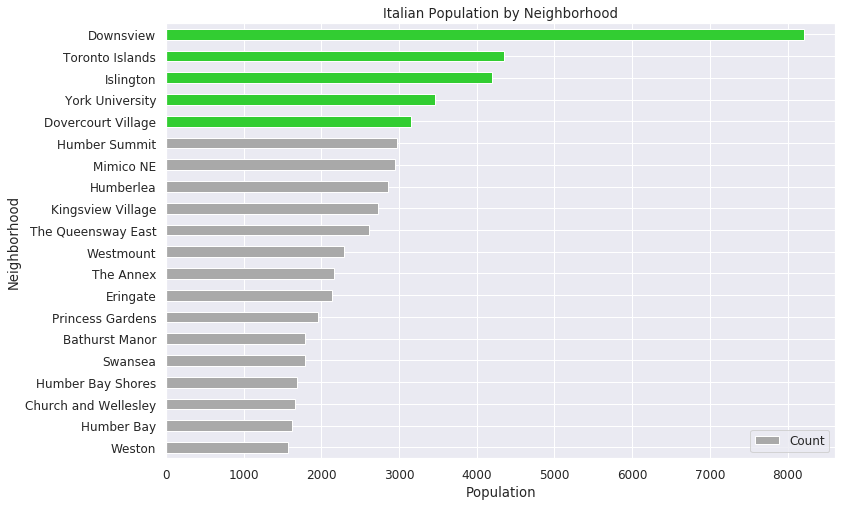

In [52]:
# Differentiating the colours of the bars
colors = ['darkgrey','darkgrey','darkgrey','darkgrey','darkgrey','darkgrey','darkgrey','darkgrey','darkgrey',
          'darkgrey','darkgrey','darkgrey','darkgrey','darkgrey','darkgrey','limegreen','limegreen','limegreen','limegreen','limegreen']

# Plotting the chart
bar_graph = italian_population.head(20).sort_values(by='Count', ascending=True)
bar_graph.plot(kind='barh',x='Neighborhood', y='Count',figsize=(12,8), color=colors)

plt.title("Italian Population by Neighborhood")
plt.xlabel("Population")
plt.ylabel("Neighborhood")

plt.show()

Another way to visualize the large population would be to view the population by Borough

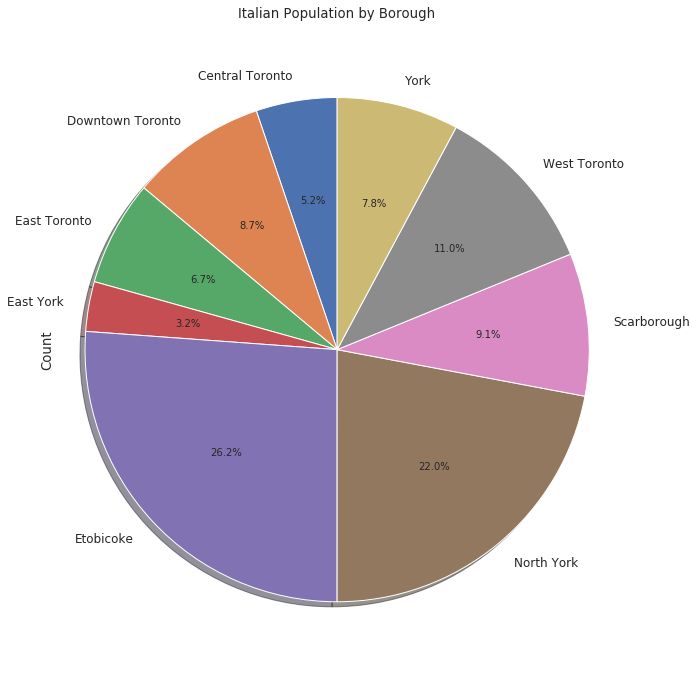

In [53]:
pop_by_borough = italian_population.set_index('Borough')
pop_by_borough = pop_by_borough.groupby(['Borough']).sum()

pop_by_borough['Count'].plot(kind='pie',
                            figsize=(10, 12),
                            autopct='%1.1f%%', # add in percentages
                            startangle=90,     # start angle 90° 
                            shadow=True,       # add shadow      
                            )

plt.title('Italian Population by Borough')
plt.axis('equal') # Sets the pie chart to look like a circle.

plt.show()

The analysis and visualization of the relationship between neighborhoods and the Italian population helps us to identifying the most densely populated Italian neighborhoods and boroughs. Once we identify those neighborhoods and boroughs,it helps us in deciding where to place the new Italian restaurant. Italian restaurants placed in an densely populated Italian neighborhood or borough would be more likely to get more Italian customers than a restaurant placed in a neighborhood with less or no Italians. This is based on the assumption that Italian customers are more accustomed to Italian cuisine. Thus this analysis helps in the determining the potential success of the new Italian restaurant in a particular neighborhood or borough.

## Exploring the relationship between Italian Restaurants and Italian Population

In [54]:
merged_italian_restaurant = pd.merge(italian_population, restaurant_by_neighborhood, on='Neighborhood')
merged_italian_restaurant = merged_italian_restaurant[['Neighborhood','Count','Italian Restaurant']]
merged_italian_restaurant.columns = ['Neighborhood','Italian Population','Italian Restaurants']
merged_italian_restaurant

Neighborhood  Italian Population  Italian Restaurants
0                  Downsview              8205.0             0.000000
1            Toronto Islands              4350.0             0.020000
2                  Islington              4195.0             0.000000
3            York University              3465.0             0.000000
4         Dovercourt Village              3155.0             0.000000
5              Humber Summit              2970.0             0.000000
6                  Mimico NE              2945.0             0.000000
7                  Humberlea              2855.0             0.000000
8          Kingsview Village              2730.0             0.000000
9         The Queensway East              2610.0             0.000000
10                 Westmount              2295.0             0.000000
11                 The Annex              2170.0             0.000000
12                  Eringate              2135.0             0.000000
13          Princess Gardens              1960.0             0.000000
14            Bathurst Manor              1785.0             0.000000
15                   Swansea              1785.0             0.052632
16         Humber Bay Shores              1685.0             0.000000
17      Church and Wellesley              1665.0             0.012195
18                Humber Bay              1620.0             0.000000
19                    Weston              1575.0             0.000000
20                    Weston              1125.0             0.000000
21              Bedford Park              1505.0             0.076923
22               The Beaches              1480.0             0.000000
23         The Danforth West              1415.0             0.071429
24         The Danforth West              1275.0             0.071429
25         The Danforth West              1160.0             0.071429
26         The Danforth West               370.0             0.071429
27                   Trinity              1370.0             0.018182
28                 High Park              1320.0             0.043478
29                 Parkwoods              1300.0             0.000000
30                   Wexford              1285.0             0.000000
31                 Alderwood              1275.0             0.000000
32           L'Amoreaux East              1270.0             0.000000
33       Caledonia-Fairbanks              1270.0             0.000000
34                 Riverdale              1230.0             0.071429
35                 Riverdale               625.0             0.071429
36                   Leaside              1230.0             0.000000
37                  Clairlea              1210.0             0.000000
38                 Cliffside              1205.0             0.000000
39             Lawrence Park              1195.0             0.000000
40             Lawrence Park              1035.0             0.000000
41             Lawrence Park               975.0             0.000000
42          Beaumond Heights              1165.0             0.000000
43                 Jamestown              1145.0             0.000000
44           Little Portugal              1115.0             0.018182
45                 West Hill              1115.0             0.000000
46        Humewood-Cedarvale              1110.0             0.000000
47             Parkview Hill              1080.0             0.000000
48  Kingsway Park South East              1075.0             0.000000
49                  Rosedale              1070.0             0.000000
50                Keelesdale              1060.0             0.000000
51           Don Mills North              1040.0             0.000000
52        Central Bay Street              1020.0             0.045977
53        The Junction North              1015.0             0.000000
54              Roncesvalles               965.0             0.076923
55                 Runnymede               935.0             0.047619
56                 Runnyme

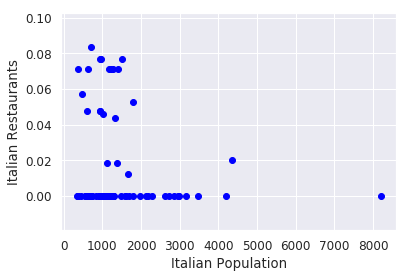

In [55]:
# Plotting a scatter plot
plt.scatter(merged_italian_restaurant['Italian Population'], merged_italian_restaurant['Italian Restaurants'],  color='blue')
plt.xlabel("Italian Population")
plt.ylabel("Italian Restaurants")
plt.show()

After performing the data cleansing and data analysis we can identify from the scatter plot that there is no strong relationship between the Italian population and the number of Italian restaurants, therefore population is not a good indicator of the presence of Italian restaurants.

Thus this marks end of the data cleaning & analyses step in this project. Next we will look into the predictive modeling. In the predictive modelling we are going to use Clustering techniques since this is analysis of unlabelled data. K-Means clustering is used to perform the analysis of the data at hand.

# 4. Predictive Modeling

## Clustering Neighborhoods of Toronto:

First step in K-means clustering is to identify best K value meaning the number of clusters in a given dataset. To do so we are going to use the elbow method on the Toronto dataset with Restaurant by neighborhood (i.e. toronto_merged dataframe).

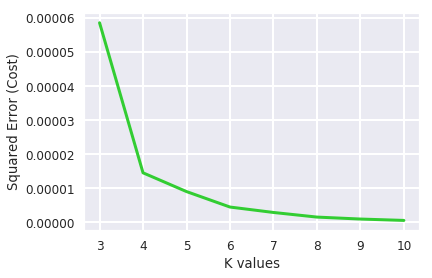

In [56]:
from sklearn.cluster import KMeans

toronto_part_clustering = restaurant_by_neighborhood.drop('Neighborhood', 1)


error_cost = []

for i in range(3,11):
    KM = KMeans(n_clusters = i, max_iter = 100)
    try:
        KM.fit(toronto_part_clustering)
    except ValueError:
        print("error on line",i)
    
    
    
    
    #calculate squared error for the clustered points
    error_cost.append(KM.inertia_/100)

#plot the K values aganist the squared error cost
plt.plot(range(3,11), error_cost, color='limegreen', linewidth='3')
plt.xlabel('K values')
plt.ylabel('Squared Error (Cost)')
plt.grid(color='white', linestyle='-', linewidth=2)
plt.show()

In [57]:
!conda install -c districtdatalabs yellowbrick

from yellowbrick.cluster import KElbowVisualizer

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - yellowbrick


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pytest-runner-5.2          |             py_0          13 KB
    yellowbrick-1.0.1          |           py36_0         429 KB  districtdatalabs
    certifi-2019.11.28         |           py36_0         156 KB
    ------------------------------------------------------------
                                           Total:         598 KB

The following NEW packages will be INSTALLED:

    pytest-runner: 5.2-py_0                          
    yellowbrick:   1.0.1-py36_0      districtdatalabs

The following packages will be UPDATED:

    certifi:       2019.11.28-py36_0 conda-forge      --> 2019.11.28-py36_0
    openssl:       1.1.1d-h516909a_0 conda-forge      --> 1.1.1d-h7b6447c_3


pytest-runner-5.2 

/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


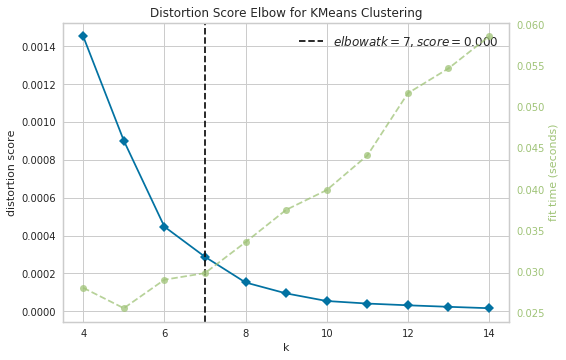

In [58]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,15))

# Fit the data to the visualizer
visualizer.fit(toronto_part_clustering)        
visualizer.show()

After analysing using elbow method using distortion score & Squared error for each K value, looks like K = 5 is the best value.

In [59]:
kclusters = 7

toronto_part_clustering = restaurant_by_neighborhood.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_part_clustering)

kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0, 5,
       0, 1, 6, 0, 3, 0, 0, 0, 0, 2, 1, 0, 0, 0, 2, 0, 5, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 6, 5, 0, 0, 0, 4, 0, 0, 0, 0, 1, 0,
       4, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 5, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 5, 4, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 2, 5, 3, 0, 0, 0, 1, 3, 0, 0, 1, 3, 0, 5, 0, 0,
       0, 0, 0, 2, 4, 4, 6, 4, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [60]:
#sorted_neighborhoods_venues.drop(['Cluster Labels'],axis=1,inplace=True)
restaurant_by_neighborhood.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_merged = toronto_dataframe
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(restaurant_by_neighborhood.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.dropna(subset=["Cluster Labels"], axis=0, inplace=True)
toronto_merged.reset_index(drop=True, inplace=True)
toronto_merged['Cluster Labels'].astype(int)
toronto_merged.head()

PostalCode           Borough      Neighborhood   Latitude  Longitude  \
0        M3A        North York         Parkwoods  43.753259 -79.329656   
1        M4A        North York  Victoria Village  43.725882 -79.315572   
2        M5A  Downtown Toronto      Harbourfront  43.654260 -79.360636   
3        M6A        North York  Lawrence Heights  43.718518 -79.464763   
4        M6A        North York    Lawrence Manor  43.718518 -79.464763   

   Cluster Labels  Italian Restaurant  
0             0.0                 0.0  
1             0.0                 0.0  
2             0.0                 0.0  
3             0.0                 0.0  
4             0.0                 0.0

In [61]:
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11, width='90%', height='70%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

## Examining the Clusters:

We have total of 7 clusters ranging 0,1,2,3,4,5,6.

Cluster 0 contains all the neighborhoods which has least number of Italian restaurants being no Italian restaurants at all. It is shown in red color in the map

In [62]:
#Cluster 0
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0]

PostalCode           Borough  \
0          M3A        North York   
1          M4A        North York   
2          M5A  Downtown Toronto   
3          M6A        North York   
4          M6A        North York   
7          M1B       Scarborough   
8          M1B       Scarborough   
9          M3B        North York   
10         M4B         East York   
11         M4B         East York   
14         M6B        North York   
15         M9B         Etobicoke   
16         M9B         Etobicoke   
17         M9B         Etobicoke   
18         M9B         Etobicoke   
19         M9B         Etobicoke   
20         M1C       Scarborough   
21         M1C       Scarborough   
22         M1C       Scarborough   
25         M4C         East York   
27         M6C              York   
28         M9C         Etobicoke   
29         M9C         Etobicoke   
30         M9C         Etobicoke   
31         M9C         Etobicoke   
32         M1E       Scarborough   
33         M1E       Scarborough   
34         M1E       Scarborough   
35         M4E      East Toronto   
37         M6E              York   
38         M1G       Scarborough   
39         M4G         East York   
42         M1H       Scarborough   
43         M2H        North York   
44         M3H        North York   
45         M3H        North York   
46         M3H        North York   
47         M4H         East York   
48         M5H  Downtown Toronto   
49         M5H  Downtown Toronto   
50         M5H  Downtown Toronto   
51         M6H      West Toronto   
52         M6H      West Toronto   
53         M1J       Scarborough   
54         M2J        North York   
55         M2J        North York   
56         M2J        North York   
57         M3J        North York   
58         M3J        North York   
59         M4J         East York   
65         M1K       Scarborough   
66         M1K       Scarborough   
67         M1K       Scarborough   
68         M2K        North York   
69         M3K        North York   
70         M3K        North York   
78         M1L       Scarborough   
79         M1L       Scarborough   
80         M1L       Scarborough   
81         M2L        North York   
82         M2L        North York   
83         M3L        North York   
88         M6L        North York   
89         M6L        North York   
90         M6L        North York   
91         M9L        North York   
92         M1M       Scarborough   
93         M1M       Scarborough   
94         M1M       Scarborough   
95         M3M        North York   
99         M6M              York   
100        M6M              York   
101        M6M              York   
102        M6M              York   
103        M9M        North York   
104        M9M        North York   
105        M1N       Scarborough   
106        M1N       Scarborough   
107        M2N        North York   
108        M3N        North York   
109        M4N   Central Toronto   
110        M5N   Central Toronto   
111        M6N              York   
113        M9N              York   
114        M1P       Scarborough   
115        M1P       Scarborough   
116        M1P       Scarborough   
117        M2P        North York   
118        M4P   Central Toronto   
119        M5P   Central Toronto   
120        M5P   Central Toronto   
123        M9P         Etobicoke   
124        M1R       Scarborough   
125        M1R       Scarborough   
126        M2R        North York   
127        M4R   Central Toronto   
128        M5R   Central Toronto   
129        M5R   Central Toronto   
130        M5R   Central Toronto   
133        M7R       Mississauga   
134        M9R         Etobicoke   
135        M9R         Etobicoke   
136        M9R         Etobicoke   
137        M9R         Etobicoke   
138        M1S       Scarborough   
147        M4T   Central Toronto   
148        M4T   Central Toronto   
149        M5T  Downtown Toronto   
150        M5T  Downtown Toronto   
151        M5T  Downtown Toronto   
152     

In [63]:
#Cluster 1
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1]

PostalCode           Borough           Neighborhood   Latitude  Longitude  \
41         M6G  Downtown Toronto               Christie  43.669542 -79.422564   
84         M4L      East Toronto       The Beaches West  43.668999 -79.315572   
85         M4L      East Toronto           India Bazaar  43.668999 -79.315572   
139        M4S   Central Toronto             Davisville  43.704324 -79.388790   
140        M5S  Downtown Toronto                Harbord  43.662696 -79.400049   
141        M5S  Downtown Toronto  University of Toronto  43.662696 -79.400049   
143        M6S      West Toronto                Swansea  43.651571 -79.484450   

     Cluster Labels  Italian Restaurant  
41              1.0            0.058824  
84              1.0            0.052632  
85              1.0            0.052632  
139             1.0            0.060606  
140             1.0            0.057143  
141             1.0            0.057143  
143             1.0            0.052632

In [64]:
#Cluster 2
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2]

PostalCode           Borough                     Neighborhood   Latitude  \
5          M7A  Downtown Toronto                     Queen's Park  43.662301   
6          M9A      Queen's Park                     Queen's Park  43.667856   
26         M5C  Downtown Toronto                   St. James Town  43.651494   
73         M5K  Downtown Toronto                  Design Exchange  43.647177   
74         M5K  Downtown Toronto          Toronto Dominion Centre  43.647177   
86         M5L  Downtown Toronto                   Commerce Court  43.648198   
87         M5L  Downtown Toronto                   Victoria Hotel  43.648198   
181        M5W  Downtown Toronto  Stn A PO Boxes 25 The Esplanade  43.646435   
186        M4X  Downtown Toronto                   St. James Town  43.667967   

     Longitude  Cluster Labels  Italian Restaurant  
5   -79.389494             2.0            0.026316  
6   -79.532242             2.0            0.026316  
26  -79.375418             2.0            0.028169  
73  -79.381576             2.0            0.030000  
74  -79.381576             2.0            0.030000  
86  -79.379817             2.0            0.030000  
87  -79.379817             2.0            0.030000  
181 -79.374846             2.0            0.031579  
186 -79.367675             2.0            0.028169

In [65]:
#Cluster 3
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3]

PostalCode       Borough         Neighborhood   Latitude  Longitude  \
71         M4K  East Toronto    The Danforth West  43.679557 -79.352188   
72         M4K  East Toronto            Riverdale  43.679557 -79.352188   
97         M5M    North York         Bedford Park  43.733283 -79.419750   
98         M5M    North York  Lawrence Manor East  43.733283 -79.419750   
131        M6R  West Toronto             Parkdale  43.648960 -79.456325   
132        M6R  West Toronto         Roncesvalles  43.648960 -79.456325   
144        M1T   Scarborough       Clarks Corners  43.781638 -79.304302   
145        M1T   Scarborough             Sullivan  43.781638 -79.304302   
146        M1T   Scarborough        Tam O'Shanter  43.781638 -79.304302   

     Cluster Labels  Italian Restaurant  
71              3.0            0.071429  
72              3.0            0.071429  
97              3.0            0.076923  
98              3.0            0.076923  
131             3.0            0.076923  
132             3.0            0.076923  
144             3.0            0.083333  
145             3.0            0.083333  
146             3.0            0.083333

In [66]:
#Cluster 4
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4]

PostalCode           Borough       Neighborhood   Latitude  Longitude  \
12        M5B  Downtown Toronto            Ryerson  43.657162 -79.378937   
13        M5B  Downtown Toronto    Garden District  43.657162 -79.378937   
36        M5E  Downtown Toronto        Berczy Park  43.644771 -79.373306   
60        M5J  Downtown Toronto  Harbourfront East  43.640816 -79.381752   
61        M5J  Downtown Toronto    Toronto Islands  43.640816 -79.381752   
62        M5J  Downtown Toronto      Union Station  43.640816 -79.381752   
63        M6J      West Toronto    Little Portugal  43.647927 -79.419750   
64        M6J      West Toronto            Trinity  43.647927 -79.419750   

    Cluster Labels  Italian Restaurant  
12             4.0            0.020000  
13             4.0            0.020000  
36             4.0            0.017857  
60             4.0            0.020000  
61             4.0            0.020000  
62             4.0            0.020000  
63             4.0            0.018182  
64             4.0            0.018182

In [67]:
#Cluster 5
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5]

PostalCode           Borough        Neighborhood   Latitude  Longitude  \
23         M3C        North York     Flemingdon Park  43.725900 -79.340923   
24         M3C        North York     Don Mills South  43.725900 -79.340923   
40         M5G  Downtown Toronto  Central Bay Street  43.657952 -79.387383   
75         M6K      West Toronto            Brockton  43.636847 -79.428191   
76         M6K      West Toronto    Exhibition Place  43.636847 -79.428191   
77         M6K      West Toronto    Parkdale Village  43.636847 -79.428191   
96         M4M      East Toronto     Studio District  43.659526 -79.340923   
112        M6N              York           Runnymede  43.673185 -79.487262   
121        M6P      West Toronto           High Park  43.661608 -79.464763   
122        M6P      West Toronto  The Junction South  43.661608 -79.464763   
142        M6S      West Toronto           Runnymede  43.651571 -79.484450   
185        M4X  Downtown Toronto         Cabbagetown  43.667967 -79.367675   

     Cluster Labels  Italian Restaurant  
23              5.0            0.045455  
24              5.0            0.045455  
40              5.0            0.045977  
75              5.0            0.045455  
76              5.0            0.045455  
77              5.0            0.045455  
96              5.0            0.046512  
112             5.0            0.047619  
121             5.0            0.043478  
122             5.0            0.043478  
142             5.0            0.047619  
185             5.0            0.047619

In [68]:
#Cluster 6
toronto_merged.loc[toronto_merged['Cluster Labels'] == 6]

PostalCode           Borough          Neighborhood   Latitude  Longitude  \
187        M5X  Downtown Toronto  First Canadian Place  43.648429  -79.38228   
188        M5X  Downtown Toronto      Underground city  43.648429  -79.38228   
192        M4Y  Downtown Toronto  Church and Wellesley  43.665860  -79.38316   

     Cluster Labels  Italian Restaurant  
187             6.0            0.010000  
188             6.0            0.010000  
192             6.0            0.012195

From the cluster analysis, it can be observed that Cluster 0 has the least number of Italian restaurants while cluster 3 show the greatest density of Italian restaurants. 

# 5. Results and Discussion:

## Results

The results section documents all the findings from above clustering and visualization exercise on the data provided. The business problem set out to identify a good neighborhood in which to open a new Italian restaurant with the initial assumptions that Italian restaurants would be concentrated in areas with high Italian populations. We looked into all the neighborhoods in Toronto and analysed the Italian population in each neighborhood including the spread of Italian restaurants in those neighborhoods. The aim of the analysis was to come to a conclusion on which neighborhood would be a better location for opening a new Italian restaurant. 

For the analysis, data was scraped from web resources like Wikipedia, geospatial coordinates of Toronto neighborhoods, and Foursquare API, to set up a very realistic data-analysis scenario. Observations from the analysis suggested that of the 210 neighborhoods in Toronto, only 114 neighborhoods were identified as having Italian communities presents in them with the highest concentration of Italians being located in Downsview. We further analysed the concentration of Italian restaurants and visualized the data using a Violin plot. The analysis suggested that of the 11 boroughs only North York, Central Toronto, Downtown Toronto, East Toronto, West Toronto, York & Scarborough boroughs had the highest concentration of Italian restaurants in Toronto. Using a scatter plot, we were able to visulize whether there was an distinct relationship between the population density of the Italian community and the number of Italian restaurants present in a neighborhood. The results of the analysis showed that there was no distinct relationship between the population density of Italians and Italian restaurants. The analysis showed that clustering the dispersion of restaurants into 7 clusters would provide a good spread of centroids. From the K-mean clustering analysis, the cluster with the most restaurants is Cluster 3, followed by Cluster 1, then Cluster 5 followed by Cluster 2, then Cluster 4, Cluster 6 and finally Cluster 0

## Discussion

The most ideal location for an Italian restaurant would be one where there is an established market for Italian restaurants without too much competition. Cluster 3, 1 and 5 respectively have the highest concentration of Italian restaurants, which would be problematic for the new business as it would be going up against more established businesses. Cluster 0 and Cluster 6 has the least number of Italian restaurants, which could be a indicator that the market for Italian cuisine/restaurants is very weak in those areas. The options in between the clusters that are most densely populated with Italian restaurants and the areas with the least numner of restaurants are clusters 2 and cluster 4. Therefore from a competition perspective, cluster 2 and cluster 4 would represent a good balance. 

Another factor to consider when choosing an area to set up a restaurant would be market size. We have taken the Italian population of each neighborhood to be an indicator of our potential market size per neighborhood. Although our scatter plot did not suggest that there is a relationship between Italian ethnic population and the number of restaurants, as evidenced by the results of Downsview having the highest concentration of Italians but having no Italian restaurants in the area, on the surface it would still be a fair assumption that the Italian population would be more familiar with Italian cuisine than all other ethnicities. However, the results of the scatter plot warrant further research and analysis into the factors that influence the number of Italian restaurants in the area. Based on the results presented, the highest number of Italian restaurants are in East Toronto followed by West Toronto then Downtown Toronto. However, East Toronto has a smaller population than Downtown Toronto and West Toronto, furthermore West Toronto has a very high number of Italian restaurants, leaving clusters within Downtown Toronto as the more ideal locations for a new Italian restaurant as it have a fairly sizable population of Italians and does not have a very high number of competitors.

Some of the drawbacks of this analysis are that the clustering is completely based only on data obtained from Foursquare API. Furthermore, the Italian population distribution in each neighborhood is also based on the 2016 census which is not up-to date. Thus population distribution may have changed by the time of this analysis. 

# 6. Conclusion:

Throughout this project we made use of many python libraries to fetch data, manipulate its contents and analyze the datasets. We have made use of Foursquare API to explore the venues in neighborhoods of Toronto, and got a good amount of data from Wikipedia which we scraped with help of Wikipedia python library and visualized the data using various plots present in seaborn & matplotlib. We also applied machine learning technique to to predict the output given the data and used Folium to visualize it on a map. Some of the drawbacks were that this analysis can be improved further with more data and different machine learning techniques to examine relationship. Similarly we can use this project to analyse any scenario for opening any type of business, for example a spa. Hopefully, this project can help act as an initial guide to make complex decisions using data-science.